In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pickle

In [8]:
# constants
IMG_SIZE = (256, 256)
SEQUENCE_LENGTH = 75
VOCAB_SIZE = 20
TOKEN_LEN = 48

model_path = 'outputs/pix2code.keras'
code_to_index_path = 'outputs/code_to_index.pickle'
index_to_code_path = 'outputs/index_to_code.pickle'

In [9]:
# Vision model
image_input = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='img')
x = layers.Conv2D(32, 3, strides=1)(image_input)
x = layers.MaxPool2D(2)(x)
x = layers.Conv2D(64, 3, strides=1)(x)
x = layers.MaxPool2D(2)(x)
x = layers.Conv2D(128, 3, strides=1)(x)
x = layers.MaxPool2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
p = layers.Dense(1024, activation='relu')(x)
# print(p.shape)

# Language model
# First LSTM model
code_input = layers.Input(shape=(TOKEN_LEN, 1))
# x = layers.Embedding(VOCAB_SIZE, 256, mask_zero=True)(code_input)
x = layers.Masking(mask_value=0)(code_input)
x = layers.LSTM(128, return_sequences=True)(x)
qt = layers.LSTM(128)(x)
# print(qt.shape)

# Second LSTM model
rt = layers.Concatenate()([p, qt])
rt = tf.expand_dims(rt, axis=1)
x = layers.LSTM(512)(rt)
xt = layers.Dense(VOCAB_SIZE+2, activation='softmax')(x)
# xt = layers.Dense(1)(x)
# print(xt.shape)

# Model
pix2code = keras.Model(inputs=[image_input, code_input], outputs=xt)

In [10]:
pix2code.load_weights(model_path)

with open(code_to_index_path, 'rb') as f:
    code_to_index = pickle.load(f)

with open(index_to_code_path, 'rb') as f:
    index_to_code = pickle.load(f)


2024-02-03 18:33:38.666477: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 471859200 exceeds 10% of free system memory.


In [11]:
def pad_sequences(x, max_len=TOKEN_LEN):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[-max_len:]
    else: padded[:len(x)] = x
    padded = tf.expand_dims(padded, axis=1)
    return padded

def generate_code(img, max_length=80):
    img = np.array([img], dtype=np.float32)
    final_code = '<START>'
    code = [code_to_index['<START>']]
    tmp = code
    code = pad_sequences(code, max_len=TOKEN_LEN)
    for i in range(max_length):
        prediction = pix2code([img, np.array([code])], training=False)
#         print(prediction)
        prediction = tf.argmax(prediction , axis=-1)
        final_code = final_code + ' ' + index_to_code[int(prediction[0])]
        tmp.append(int(prediction[0]))
        if (len(tmp) > TOKEN_LEN):
            tmp = tmp[1:]
        code = pad_sequences(tmp, max_len=TOKEN_LEN)
        if int(prediction[0]) == code_to_index['<END>']:
            break
    print(final_code)

In [12]:
dataset_path = 'dataset/android/all_data'

img_paths = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
# img_paths.sort()

def generate_code_from_path(index):
    img = cv2.imread(os.path.join(dataset_path, img_paths[index]))
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    generate_code(img)
    plt.imshow(img)

2024-02-03 18:33:42.604679: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


<START> stack { row { check } row { switch } row { label , slider , label } row { radio } row { label , slider , label } row { switch , switch , switch } row { switch } } footer { btn-notifications , btn-home , btn-home , btn-search } <END>


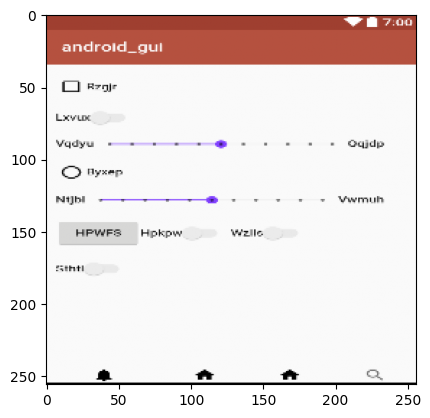

In [13]:
generate_code_from_path(10)